In [1]:
import numpy as np
import pandas as pd

import numpy as np
import csv

from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, diags

In [2]:
%%time
'''                      ##           Fill all txt in one .csv            ##                      '''

combined_data_file_name = "./combined_data_%s.txt"

target_f = open("./processed_data.csv", "w+")
for i in {1,2,3,4}:
    print("Processing data-set " + str(i) + "/4 ...")
    
    cur_movie_id = None
    with open(combined_data_file_name % i) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')

        for row in csv_reader:
            if (len(row) == 1):
                cur_movie_id = row[0][:-1]
            else:
                user_id = row[0]
                rating = row[1]
                
                target_f.write(user_id + "," + rating + "," + cur_movie_id + "\n")
    print("     Data-set " + str(i) + "/4 completed")

target_f.close()
print()

Processing data-set 1/4 ...
     Data-set 1/4 completed
Processing data-set 2/4 ...
     Data-set 2/4 completed
Processing data-set 3/4 ...
     Data-set 3/4 completed
Processing data-set 4/4 ...
     Data-set 4/4 completed

Wall time: 2min 31s


In [3]:
%%time
'''                      ##           Download dataset -> one-hot            ##                      '''

train_csv = "processed_data.csv"
columns = ["user_id", "film_rating", "film_id"]
num_of_lines = 2 * 10**6
data = pd.read_csv(train_csv, header=None, names=columns, nrows=num_of_lines)

encoder = OneHotEncoder(categories="auto")
# (number_of_ratings x number_of_users)
user_matrix = encoder.fit_transform(np.asarray(data['user_id']).reshape(-1,1))

# (number_of_ratings x number_of_movie_ids)
film_matrix = encoder.fit_transform(np.asarray(data['film_id']).reshape(-1,1))

ones = np.ones(shape=(num_of_lines, 1))
X = hstack([ones, user_matrix, film_matrix]).tocsr()
y = np.asarray(data['film_rating']).reshape(-1,1)
# do shuffling so records will be evenly distributed over the matrix    
X,y = shuffle(X,y)

Wall time: 1.61 s


In [4]:
def MSE(y, y_pred):
    return np.sum(np.square(y-y_pred))/len(y)
def RMSE(y, y_pred):
    return np.sqrt(MSE(y, y_pred))
def R2(y, y_pred):
    return 1-(np.sum(np.square(y-y_pred)))/(np.sum(np.square(y-y.mean())))

# pre-calc sum for gradient
def gr_sum(X, V):
    return X.dot(V)
def predict(X, w, V):
    a = np.sum(np.square(X.dot(V)), axis=1).reshape(-1,1)
    b = np.sum(X.power(2).dot(np.square(V)), axis=1).reshape(-1,1)
    
    return X.dot(w)+0.5*(a-b)

In [5]:
def step_of_gradient(X, y, w, V, eta):  # [!!!] there is re-calc weights here 
    # re-calc w
    w += (2 * eta / len(y)) * X.T.dot(y - X.dot(w))
    
    precomputed = gr_sum(X, V)
    y_pred = predict(X, w, V)
    
    # re-calc V_i
    for i in range(V.shape[1]):
        a_diagonal = diags(np.array(precomputed)[:, i])
        a = a_diagonal.dot(X)
        
        b_diagonal = diags(V[:, i])
        b = X.power(2).dot(b_diagonal)
        
        V[:, i] += (2 * eta / X.shape[1]) * (a - b).T.dot(y - y_pred).reshape((-1,))
    
    return w, V

def gradient(X, y, w_init, V_init, eta, max_iter):
    weight_dist = np.inf
    w = w_init
    V = V_init
    errors = list()

    for i in range(max_iter+1):
        w_next, V_next = step_of_gradient(X, y, w, V, eta)
        y_pred = predict(X, w_next, V_next)

        errors.append(MSE(y, y_pred))

        if i % 10 == 0 and i != 0:
            if i == 100: print(f"\tCur-Step is {i} <->  Cur-MSE is {errors[i]}")
            else:        print(f"\tCur-Step is {i}  <->  Cur-MSE is {errors[i]}")
        
        w = w_next
        V = V_next
    return w, V, errors

In [6]:
%%time
'''
                    ##           Main           ##
'''
num_of_splits = 5
number_of_steps = 100
num_of_factors = 2
# final = []

errors     = [0 for _ in range(num_of_splits)]
factors    = [0 for _ in range(num_of_splits)]
weights    = [0 for _ in range(num_of_splits)]
r2s_train  = [0 for _ in range(num_of_splits)]
r2s_test   = [0 for _ in range(num_of_splits)]
rmse_train = [0 for _ in range(num_of_splits)]
rmse_test  = [0 for _ in range(num_of_splits)]

kf = KFold(n_splits=num_of_splits, shuffle=True)
kf.get_n_splits(X)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Processing {i + 1} era ... ")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    w_init = np.zeros((X.shape[1], 1))
    V_init = np.zeros((X.shape[1], num_of_factors))
    
    results = gradient(X_train, y_train, w_init, V_init, eta=0.02, max_iter=number_of_steps)

    # Setting params for Out-doc:
    weights[i], factors[i], errors[i] = results
    train_preds = predict(X_train, weights[i], factors[i])
    test_preds = predict(X_test, weights[i], factors[i])
    rmse_train[i] = RMSE(y_train, train_preds)
    rmse_test[i] = RMSE(y_test, test_preds)
    r2s_train[i] = R2(y_train, train_preds)
    r2s_test[i] = R2(y_test, test_preds)
    
print()

Processing 1 era ... 
	Cur-Step is 10  <->  Cur-MSE is 6.380132792192279
	Cur-Step is 20  <->  Cur-MSE is 3.411156807349815
	Cur-Step is 30  <->  Cur-MSE is 2.1245085692511063
	Cur-Step is 40  <->  Cur-MSE is 1.5666527595807063
	Cur-Step is 50  <->  Cur-MSE is 1.3245183798419387
	Cur-Step is 60  <->  Cur-MSE is 1.219163158178651
	Cur-Step is 70  <->  Cur-MSE is 1.1730692106927703
	Cur-Step is 80  <->  Cur-MSE is 1.1526556258799685
	Cur-Step is 90  <->  Cur-MSE is 1.1433749611073099
	Cur-Step is 100 <->  Cur-MSE is 1.1389250642104034
Processing 2 era ... 
	Cur-Step is 10  <->  Cur-MSE is 6.3809854315592975
	Cur-Step is 20  <->  Cur-MSE is 3.4108885005135945
	Cur-Step is 30  <->  Cur-MSE is 2.123747753583092
	Cur-Step is 40  <->  Cur-MSE is 1.5656740649330954
	Cur-Step is 50  <->  Cur-MSE is 1.3234418432674635
	Cur-Step is 60  <->  Cur-MSE is 1.2180412731364556
	Cur-Step is 70  <->  Cur-MSE is 1.1719249614135803
	Cur-Step is 80  <->  Cur-MSE is 1.1514991045049128
	Cur-Step is 90  <->  Cu

In [7]:
# Predicted values:
pd.DataFrame(train_preds), pd.DataFrame(test_preds)

(                0
 0        3.569634
 1        3.549650
 2        3.657513
 3        3.569747
 4        3.699566
 ...           ...
 1599995  3.501995
 1599996  3.493134
 1599997  3.485640
 1599998  3.484276
 1599999  3.604393
 
 [1600000 rows x 1 columns],
                0
 0       3.497204
 1       3.506537
 2       3.566652
 3       3.491266
 4       3.500926
 ...          ...
 399995  3.528571
 399996  3.498796
 399997  3.506532
 399998  3.556073
 399999  3.563527
 
 [400000 rows x 1 columns])

Populating the interactive namespace from numpy and matplotlib
Wall time: 203 ms


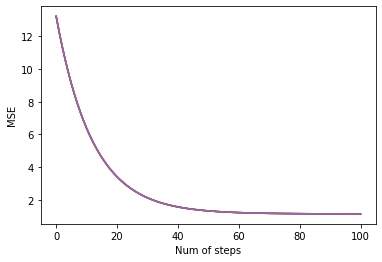

In [8]:
%%time
%pylab inline

for error_by_iter in errors:
    plot(range(len(error_by_iter)), error_by_iter)
    xlabel('Num of steps')
    ylabel('MSE')

In [9]:
%%time
'''
                    ##           Output           ##
'''

columns = ["SubaevR"]
columns += [f"T{i + 1}" for i in range(num_of_splits)]
columns.append("Mean")
columns.append("Std")

rows =  ["RMSE-train", "RMSE-test", "R2-train", "R2-test"]
rows += [f"Feature {i + 1}" for i in range(len(weights[0]))]


result_dataframe = pd.DataFrame(columns=columns)
result_dataframe["SubaevR"] = rows
result_dataframe.set_index("SubaevR", inplace=True)

for i in range(num_of_splits):
    data = np.concatenate(([rmse_train[i], rmse_test[i], r2s_train[i], r2s_test[i]], weights[i].reshape((-1,))))
    result_dataframe[f"T{i + 1}"] = data

result_dataframe["Mean"] = result_dataframe.mean(axis=1)
result_dataframe["Std"] = result_dataframe.std(axis=1)

with pd.ExcelWriter("SubaevRuslan_2.xlsx") as writer:
    result_dataframe.to_excel(writer)

result_dataframe

Wall time: 58.7 s


,T1,T2,T3,T4,T5,Mean,Std
SubaevR,,,,,,,
RMSE-train,1.067204,1.066656,1.067276,1.067278,1.066769,1.067037,0.000268
RMSE-test,1.066449,1.068432,1.066122,1.066088,1.068120,1.067042,0.001020
R2-train,0.014367,0.014536,0.014410,0.014357,0.014542,0.014442,0.000081
R2-test,0.014591,0.014300,0.014492,0.014754,0.014019,0.014431,0.000253
Feature 1,3.484035,3.484633,3.484275,3.484193,3.484202,3.484268,0.000199
...,...,...,...,...,...,...,...
Feature 342803,0.113208,0.112846,0.113155,0.113167,0.112877,0.113050,0.000156
Feature 342804,0.005150,0.005020,0.005048,0.005075,0.005230,0.005105,0.000076
Feature 342805,0.013403,0.013332,0.013484,0.013365,0.013523,0.013421,0.000072
